<a href="https://colab.research.google.com/github/ndtuan10/Neural-network-and-Genetic-algorithms_CS410.M11.KHCL/blob/main/Neural%20Network/MLP-LeNet_5_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Ngô Đức Tuấn**

MSSV: 18520186

##**Bài tập 5: MLP and LeNet-5 model on CIFAR10 dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**CIFAR10 dataset**

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

- Colour images.
- Each image is stored as a matrix has 32 x 32 x 3 size.
- 10 classes
    + 0 airplane
    + 1 automobile
    + 2 bus
    + 3 cat
    + 4 deer
    + 5 dog
    + 6 frog
    + 7 horse
    + 8 ship
    + 9 truck
- 50K samples in training set.
- 10K samples in testing set.

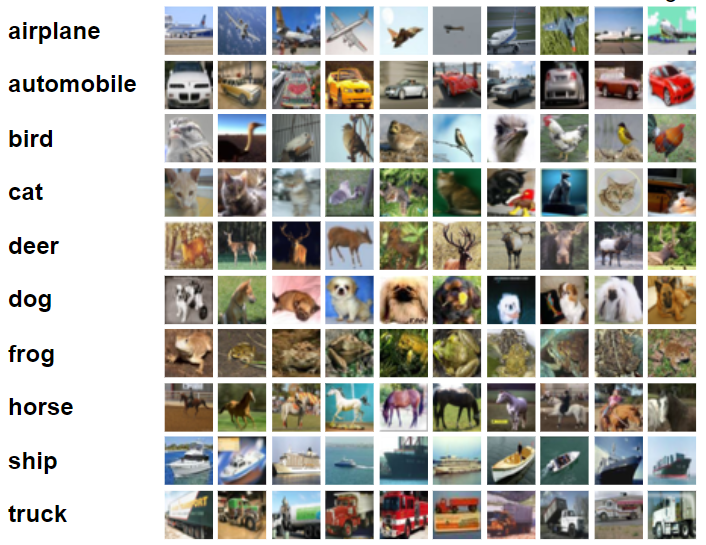

#**I. MLP**

#**1. Import necessary libraries**

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Build model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # Training strategy
from torch.utils.data import DataLoader # Split data
import torchvision.datasets as datasets # Load data
import torchvision.transforms as transforms # Data preprocessing

#**2. Data preprocessing**

In [ ]:
# Check whether we are using 'GPU' or 'CPU'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Setup for getting the reproducibility of results
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

##**Hyperparameters**

In [ ]:
input_size = 3072 # 32 x 32 x 3
n_classes = 10 # 10 classes
learning_rate = 0.001 # learning rate on gradient descent
batch_size = 64 # the number of samples in each batch
n_epochs = 50 # the number of training epochs

##**Load 'CIFAR10' dataset**

In [ ]:
train_dataset = datasets.CIFAR10(root='/content/drive/MyDrive/Mạng neural và thuật giải di truyền/dataset/cifar10', train=True,
                                      transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.CIFAR10(root='/content/drive/MyDrive/Mạng neural và thuật giải di truyền/dataset/cifar10', train=False,
                                      transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/Mạng neural và thuật giải di truyền/dataset/cifar10/cifar-10-python.tar.gz to /content/drive/MyDrive/Mạng neural và thuật giải di truyền/dataset/cifar10
Files already downloaded and verified


##**Show an image in training set**

6


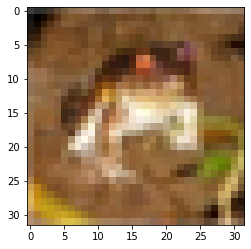

In [ ]:
image, label = train_dataset[0]
plt.imshow(image.permute((1,2,0)))
print(label)

#**3. Build a Multi Layer Perceptron model using Pytorch**

Requirements
- Problem dataset: CIFAR10
- Build a model has 4 layers: 1 **$input$** layer, 3 **$hidden$** layers, 1 **$output$** layer.
- **$input$** layer has 3072 nodes (input_size), **$hidden 1$** layer has 1024 nodes, **$hidden 2$** layer has 512 nodes, **$hidden 3$** layer has 256 nodes and **$output$** layer has 64 nodes.
- The activation of each node in **$input$** layer and **$hidden$** layers is '$ReLU$'.
- The activation of each node in **$output$** layer is '$Softmax$'.
- '$out_features$' value of **$output$** layer is 10 (n_classes).

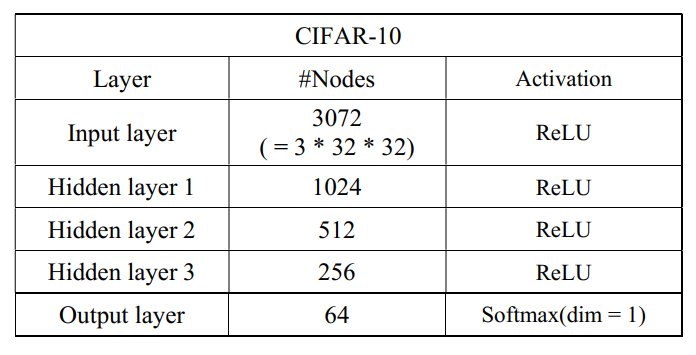

##**Compile the model**

In [ ]:
class MLP_CIFAR10(nn.Module):
    def __init__(self, input_size, n_classes):
        super().__init__()
        self.input_layer = nn.Linear(input_size, 1024)
        self.hidden_layer_1 = nn.Linear(1024, 512)
        self.hidden_layer_2 = nn.Linear(512, 256)
        self.hidden_layer_3 = nn.Linear(256, 64)
        self.output_layer = nn.Linear(64, n_classes)

    def forward(self, X):
        X = self.input_layer(X)
        X = F.relu(X)
        X = self.hidden_layer_1(X)
        X = F.relu(X)
        X = self.hidden_layer_2(X)
        X = F.relu(X)
        X = self.hidden_layer_3(X)
        X = F.relu(X)
        X = self.output_layer(X)
        prob = F.softmax(X, dim=1)
        return prob

In [ ]:
model = MLP_CIFAR10(input_size=input_size, n_classes=n_classes).to(device)
print(model)

MLP_CIFAR10(
  (input_layer): Linear(in_features=3072, out_features=1024, bias=True)
  (hidden_layer_1): Linear(in_features=1024, out_features=512, bias=True)
  (hidden_layer_2): Linear(in_features=512, out_features=256, bias=True)
  (hidden_layer_3): Linear(in_features=256, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=10, bias=True)
)


##**Define the loss and the optimization algorithm**

In [ ]:
criterion = nn.CrossEntropyLoss() # loss function = Cross entropy
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Optimizer = Adam

#**4.Training model**

In [ ]:
for epoch in range(n_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to GPU
        data = data.to(device) # Put our images to the GPU if GPU is available
        targets = targets.to(device)

        # Change to the correct tensor shape
        # Our data is in the form (batch_size, color_channel, w, h) (64, 3, 28, 28)
        # We need to change it to (batch_size, color_channel * w * h) (64, 3072)
        data = data.reshape(data.shape[0], -1)

        # forward pass
        scores = model(data)
        loss = criterion(scores, targets) # compute the loss/cost function J for this batch

        # backward pass
        optimizer.zero_grad() # empty the optimizer first
        loss.backward() # compute the gradient dJ/dw's

        # gradient descent
        optimizer.step()

        if (batch_idx+1) % 100 == 0:
            print(f'Epoch {epoch+1}/{n_epochs}, Batch{batch_idx+1}, Loss: {loss.item():.2f}')

Epoch 1/50, Batch100, Loss: 2.23
Epoch 1/50, Batch200, Loss: 2.23
Epoch 1/50, Batch300, Loss: 2.19
Epoch 1/50, Batch400, Loss: 2.22
Epoch 1/50, Batch500, Loss: 2.21
Epoch 1/50, Batch600, Loss: 2.21
Epoch 1/50, Batch700, Loss: 2.18
Epoch 2/50, Batch100, Loss: 2.22
Epoch 2/50, Batch200, Loss: 2.11
Epoch 2/50, Batch300, Loss: 2.09
Epoch 2/50, Batch400, Loss: 2.20
Epoch 2/50, Batch500, Loss: 2.13
Epoch 2/50, Batch600, Loss: 2.00
Epoch 2/50, Batch700, Loss: 2.11
Epoch 3/50, Batch100, Loss: 2.14
Epoch 3/50, Batch200, Loss: 2.09
Epoch 3/50, Batch300, Loss: 2.10
Epoch 3/50, Batch400, Loss: 2.17
Epoch 3/50, Batch500, Loss: 2.14
Epoch 3/50, Batch600, Loss: 2.20
Epoch 3/50, Batch700, Loss: 2.15
Epoch 4/50, Batch100, Loss: 2.09
Epoch 4/50, Batch200, Loss: 2.13
Epoch 4/50, Batch300, Loss: 2.07
Epoch 4/50, Batch400, Loss: 2.17
Epoch 4/50, Batch500, Loss: 2.21
Epoch 4/50, Batch600, Loss: 2.08
Epoch 4/50, Batch700, Loss: 2.09
Epoch 5/50, Batch100, Loss: 2.08
Epoch 5/50, Batch200, Loss: 2.16
Epoch 5/50

#**5. Performance Evaluation**

In [ ]:
def get_accuracy(loader, model):
    if loader.dataset.train:
        print('Getting accuracy on training data')
    else:
        print('Getting accuracy on testing data')
    
    n_corrects = 0
    n_samples = 0
    model.eval() # put our model to evaluation mode

    with torch.no_grad(): # no need to compute gradient here
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            x = x.reshape(x.shape[0], -1)

            #forward
            scores = model(x) # scores 64 x 10
            _, y_pred = scores.max(1)
            n_corrects += (y_pred == y).sum()
            n_samples += y_pred.size(0)
       
        print(f'We got {n_corrects}/{n_samples} correct. Accuracy = {float(n_corrects)/float(n_samples)*100.0:.2f}')
    model.train() # put our model to train mode again

In [ ]:
get_accuracy (train_loader, model)
get_accuracy (test_loader, model)

Getting accuracy on training data
We got 20852/50000 correct. Accuracy = 41.70
Getting accuracy on testing data
We got 4052/10000 correct. Accuracy = 40.52


#**II. LeNet-5**

#**1. Import necessary libraries**
- like step I

#**2. Data preprocessing**

In [ ]:
# Check whether we are using 'GPU' or 'CPU'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Setup for getting the reproducibility of results
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

##**Hyperparameters**

In [ ]:
n_classes = 10 # 10 classes
learning_rate = 0.001 # learning rate on gradient descent
batch_size = 64 # the number of samples in each batch
n_epochs = 50 # the number of training epochs

##**Load 'CIFAR10' dataset**

In [ ]:
train_dataset = datasets.CIFAR10(root='/content/drive/MyDrive/Mạng neural và thuật giải di truyền/dataset/cifar10', train=True,
                                      transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.CIFAR10(root='/content/drive/MyDrive/Mạng neural và thuật giải di truyền/dataset/cifar10', train=False,
                                      transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


##**Show an image in training set**

6


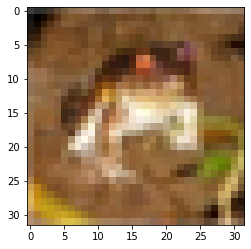

In [ ]:
image, label = train_dataset[0]
plt.imshow(image.permute((1,2,0)))
print(label)

#**3. Build LeNet-5 model using PyTorch**

##**Comple the model**

In [ ]:
class LeNet5_CIFAR10(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.Flatten(),
            nn.Linear(in_features=120, out_features=84),
            nn.Linear(in_features=84, out_features=n_classes),
            nn.Softmax(dim=1)
        )
    
    def forward(self, X):
        prob = self.model(X)
        return prob

In [ ]:
model = LeNet5_CIFAR10(n_classes=n_classes).to(device)
print(model)

LeNet5_CIFAR10(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): Linear(in_features=84, out_features=10, bias=True)
    (11): Softmax(dim=1)
  )
)


##**Define the loss and the optimization algorithm**

In [ ]:
criterion = nn.CrossEntropyLoss() # loss function = Cross entropy
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Optimizer = Adam

#**4.Training model**

In [ ]:
for epoch in range(n_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to GPU
        data = data.to(device) # Put our images to the GPU if GPU is available
        targets = targets.to(device)

        # We don't need to reshape the image to vector format
        # because the input of LeNet-5 is an image 32 x 32.
        # data = data.reshape(data.shape[0], -1)

        # forward pass
        scores = model(data)
        loss = criterion(scores, targets) # compute the loss/cost function J for this batch

        # backward pass
        optimizer.zero_grad() # empty the optimizer first
        loss.backward() # compute the gradient dJ/dw's

        # gradient descent
        optimizer.step()

        if (batch_idx+1) % 100 == 0:
            print(f'Epoch {epoch+1}/{n_epochs}, Batch{batch_idx+1}, Loss: {loss.item():.2f}')

Epoch 1/50, Batch100, Loss: 2.16
Epoch 1/50, Batch200, Loss: 2.17
Epoch 1/50, Batch300, Loss: 2.17
Epoch 1/50, Batch400, Loss: 2.06
Epoch 1/50, Batch500, Loss: 2.14
Epoch 1/50, Batch600, Loss: 2.02
Epoch 1/50, Batch700, Loss: 2.12
Epoch 2/50, Batch100, Loss: 2.02
Epoch 2/50, Batch200, Loss: 2.02
Epoch 2/50, Batch300, Loss: 2.13
Epoch 2/50, Batch400, Loss: 2.09
Epoch 2/50, Batch500, Loss: 2.06
Epoch 2/50, Batch600, Loss: 2.15
Epoch 2/50, Batch700, Loss: 2.03
Epoch 3/50, Batch100, Loss: 2.01
Epoch 3/50, Batch200, Loss: 2.02
Epoch 3/50, Batch300, Loss: 1.97
Epoch 3/50, Batch400, Loss: 2.09
Epoch 3/50, Batch500, Loss: 2.13
Epoch 3/50, Batch600, Loss: 1.99
Epoch 3/50, Batch700, Loss: 2.00
Epoch 4/50, Batch100, Loss: 2.01
Epoch 4/50, Batch200, Loss: 2.07
Epoch 4/50, Batch300, Loss: 1.98
Epoch 4/50, Batch400, Loss: 2.00
Epoch 4/50, Batch500, Loss: 2.09
Epoch 4/50, Batch600, Loss: 1.97
Epoch 4/50, Batch700, Loss: 1.95
Epoch 5/50, Batch100, Loss: 2.03
Epoch 5/50, Batch200, Loss: 2.04
Epoch 5/50

#**5. Performance Evaluation**

In [ ]:
def get_accuracy(loader, model):
    if loader.dataset.train:
        print('Getting accuracy on training data')
    else:
        print('Getting accuracy on testing data')
    
    n_corrects = 0
    n_samples = 0
    model.eval() # put our model to evaluation mode

    with torch.no_grad(): # no need to compute gradient here
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            # x = x.reshape(x.shape[0], -1)

            #forward
            scores = model(x) # scores 64 x 10
            _, y_pred = scores.max(1)
            n_corrects += (y_pred == y).sum()
            n_samples += y_pred.size(0)
       
        print(f'We got {n_corrects}/{n_samples} correct. Accuracy = {float(n_corrects)/float(n_samples)*100.0:.2f}')
    model.train() # put our model to train mode again

In [ ]:
get_accuracy (train_loader, model)
get_accuracy (test_loader, model)

Getting accuracy on training data
We got 31558/50000 correct. Accuracy = 63.12
Getting accuracy on testing data
We got 5034/10000 correct. Accuracy = 50.34


# **So sánh kết quả**

In [ ]:
import pandas as pd

In [ ]:
results_dict={'Model':['MLP', 'LeNet-5'],
              'Accuracy on training data':['41.70%', '63.12%'],
              'Accuracy on testing data':['40.52%', '50.34%'],
              'Time':['578.0s', '607.4s'],}
pd.DataFrame(results_dict)

,Model,Accuracy on training data,Accuracy on testing data,Time
0,MLP,41.70%,40.52%,578.0s
1,LeNet-5,63.12%,50.34%,607.4s
